In [ ]:
import matplotlib.pyplot as plt
import joblib
import numpy as np
import torch
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.patches as mpatches
import torch.nn.functional as F

In [3]:
model = joblib.load('./models/cloud_detector.pkl')

In [4]:
if torch.backends.mps.is_available():
    DEVICE = "mps"
elif torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

print(f"Using device: {DEVICE}")

Using device: mps


In [ ]:
%pip install ipynb
from ipynb.fs.defs.cloud_detection import CloudDataset

In [6]:
test_features = "data/test_features"
test_labels = "data/test_labels"

test_chips = sorted([d for d in os.listdir(test_features) if os.path.isdir(os.path.join(test_features, d))])
val_dataset = CloudDataset(test_chips, test_features, test_labels)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

### Prediction Visualisation  

In [25]:
def visualize_predictions(model, dataloader, num_batches, alpha=0.5):
    model.eval()
    device = next(model.parameters()).device

    data_iter = iter(dataloader)

    for batch_idx in range(num_batches):
        try:
            images, true_masks = next(data_iter)
        except StopIteration:
            print("Reached end of dataloader before completing requested batches")
            break

        images, true_masks = images.to(device), true_masks.to(device)

        # Get model predictions
        with torch.no_grad():
            outputs = model(images)
            if outputs.shape[1] > 1:  # If multi-class
                probs = F.softmax(outputs, dim=1)
                preds = torch.argmax(outputs, dim=1)
            else:  # Binary segmentation
                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).squeeze(1).long()

        
        for i in range(len(images)):
            img = images[i].cpu().numpy()
            true_mask = true_masks[i].cpu().numpy()
            pred_mask = preds[i].cpu().numpy()
            prob_map = probs[i][1].cpu().numpy() if probs.shape[1] > 1 else probs[i][0].cpu().numpy()

            if img.shape[0] > 3:
                img_rgb = img[[3, 2, 1], :, :]
                img_rgb = np.transpose(img_rgb, (1, 2, 0))
            else:
                img_rgb = np.transpose(img[:3], (1, 2, 0))

            img_rgb = (img_rgb - img_rgb.min()) / (img_rgb.max() - img_rgb.min())

            fig, axes = plt.subplots(2, 4, figsize=(15, 5))
            fig.suptitle(f'Batch {batch_idx+1} Chip {i+1} Predictions', fontsize=16)

            # Plot original image
            axes[0,0].imshow(img_rgb)
            axes[0,0].set_title('Input Image')
            axes[0,0].axis('off')

            # Plot true mask
            axes[0,1].imshow(true_mask, cmap='gray')
            axes[0,1].set_title('Ground Truth')
            axes[0,1].axis('off')

            # Plot prediction
            axes[0,2].imshow(pred_mask, cmap='gray')
            axes[0,2].set_title('Predicted Mask')
            axes[0,2].axis('off')

            # Plot probability map
            axes[0,3].imshow(prob_map, cmap='viridis')
            axes[0,3].set_title('Cloud Probability')
            axes[0,3].axis('off')


            # Plot difference (errors)
            difference = np.abs(true_mask - pred_mask)
            axes[1,0].imshow(img_rgb)
            axes[1,0].imshow(difference, alpha=alpha, cmap='Reds')

            true_pos = mpatches.Patch(color='red', label='Error (FP/FN)')
            axes[1,0].legend(handles=[true_pos], loc='upper right')
            axes[1,0].set_title('Prediction Errors (Red)')
            axes[1,0].axis('off')

            # True mask overlay
            axes[1,1].imshow(img_rgb)
            axes[1,1].imshow(true_mask, alpha=alpha, cmap='Blues')
            axes[1,1].set_title('Ground Truth Overlay')
            axes[1,1].axis('off')

            # Predicted mask overlay
            axes[1,2].imshow(img_rgb)
            axes[1,2].imshow(pred_mask, alpha=alpha, cmap='Oranges')
            axes[1,2].set_title('Prediction Overlay')
            axes[1,2].axis('off')

            # Combined overlay
            axes[1,3].imshow(img_rgb)
            axes[1,3].imshow(np.ma.masked_where(true_mask == 0, true_mask),
                        alpha=alpha, cmap='Blues')
            axes[1,3].imshow(np.ma.masked_where(pred_mask == 0, pred_mask),
                        alpha=alpha, cmap='Oranges')

            true_patch = mpatches.Patch(color='blue', alpha=alpha, label='True Cloud')
            pred_patch = mpatches.Patch(color='orange', alpha=alpha, label='Predicted Cloud')
            axes[1,3].legend(handles=[true_patch, pred_patch], loc='lower right')
            axes[1,3].set_title('Combined Overlay')
            axes[1,3].axis('off')

            plt.tight_layout()
            plt.show()

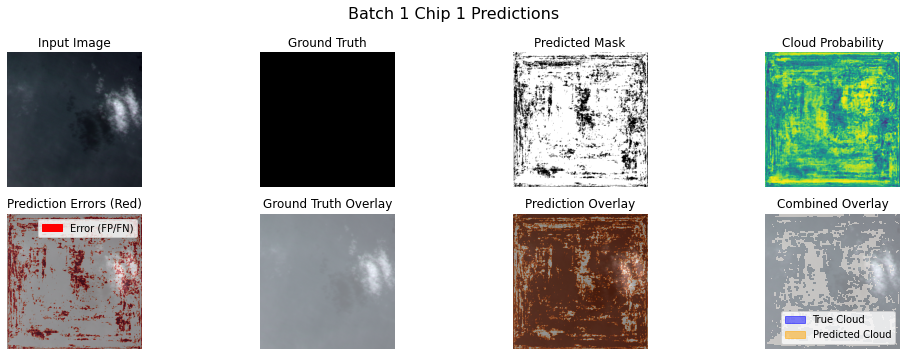

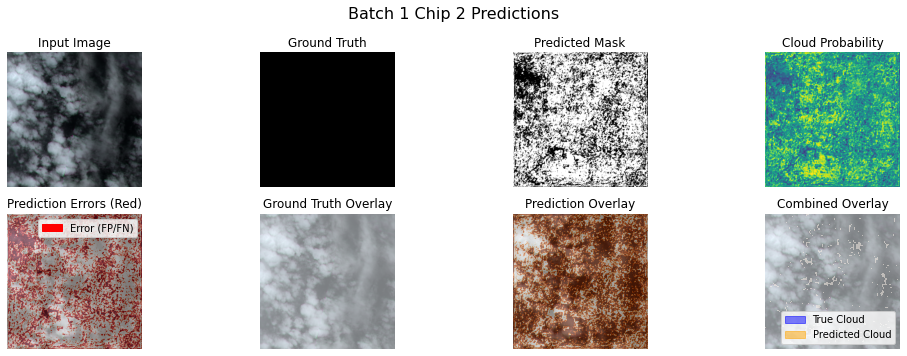

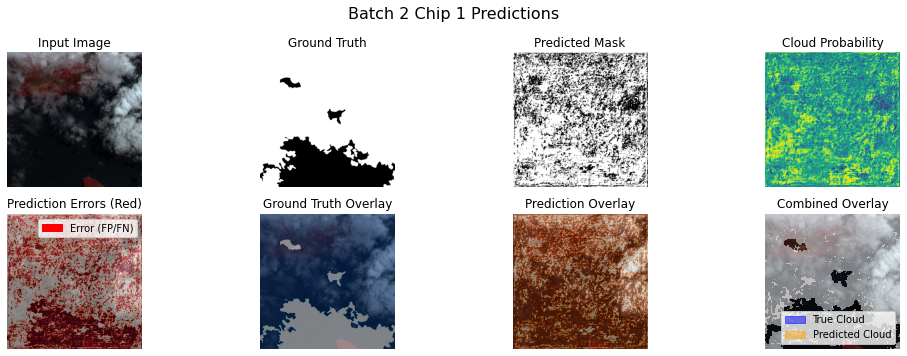

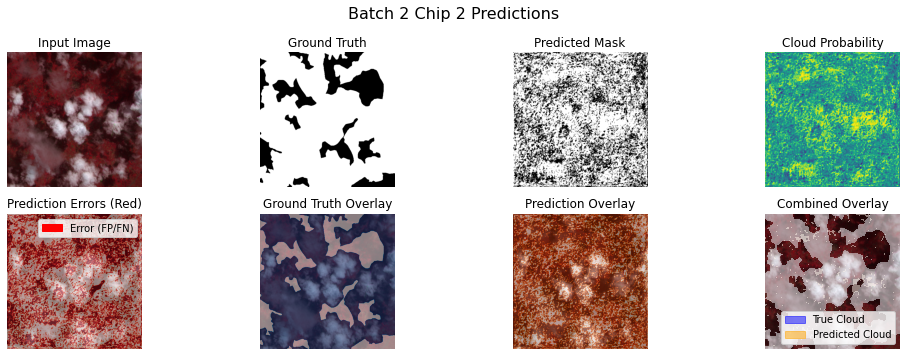

In [26]:
visualize_predictions(model, val_loader, 2)

### Evaluation Matrix

In [27]:
def calculate_metrics(model, dataloader, device=DEVICE, threshold=0.5, average='weighted'):
    
    model.eval()
    all_preds = []
    all_targets = []
    all_probs = []
    
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images)
            
            if outputs.shape[1] > 1:
                probs = F.softmax(outputs, dim=1)
                preds = torch.argmax(outputs, dim=1)
            else:
                probs = torch.sigmoid(outputs)
                preds = (probs > threshold).long().squeeze(1)
            
            all_preds.append(preds.cpu())
            all_targets.append(masks.cpu())
            all_probs.append(probs.cpu())
    
    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()
    all_probs = torch.cat(all_probs).numpy()
    
    flat_preds = all_preds.reshape(-1)
    flat_targets = all_targets.reshape(-1)
    
    precision = precision_score(flat_targets, flat_preds, average=average, zero_division=0)
    recall = recall_score(flat_targets, flat_preds, average=average, zero_division=0)
    f1 = f1_score(flat_targets, flat_preds, average=average, zero_division=0)
    
    class_metrics = {}
    if len(np.unique(flat_targets)) == 2:
        for class_idx in [0, 1]:
            class_metrics[f'class_{class_idx}'] = {
                'precision': precision_score(flat_targets, flat_preds, pos_label=class_idx, zero_division=0),
                'recall': recall_score(flat_targets, flat_preds, pos_label=class_idx, zero_division=0),
                'f1': f1_score(flat_targets, flat_preds, pos_label=class_idx, zero_division=0)
            }
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': all_preds,
        'targets': all_targets,
        'probabilities': all_probs,
        'class_metrics': class_metrics
    }

In [ ]:
def print_detailed_metrics(metrics):
    
    print("\n" + "="*50)
    print("MODEL EVALUATION METRICS")
    print("="*50)
    print(f"{'Metric':<15} {'Score':<10}")
    print("-"*25)
    print(f"{'Precision':<15} {metrics['precision']:.4f}")
    print(f"{'Recall':<15} {metrics['recall']:.4f}")
    print(f"{'F1 Score':<15} {metrics['f1']:.4f}")
    
    if metrics['class_metrics']:
        print("\nClass-wise Metrics:")
        for class_name, class_metric in metrics['class_metrics'].items():
            print(f"\n{class_name}:")
            for metric, value in class_metric.items():
                print(f"  {metric:<12} {value:.4f}")
    print("="*50 + "\n")

In [34]:
metrics = calculate_metrics(model, val_loader, device=DEVICE)
print_detailed_metrics(metrics)


MODEL EVALUATION METRICS
Metric          Score     
-------------------------
Precision       0.4808
Recall          0.4810
F1 Score        0.4809

Class-wise Metrics:

class_0:
  precision    0.2861
  recall       0.2856
  f1           0.2859

class_1:
  precision    0.5921
  recall       0.5926
  f1           0.5923

